In [1]:
### packages ###
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import modelbase
from tqdm.notebook import tqdm
from modelbase.ode import Simulator
from scipy.integrate import trapezoid
from typing import Iterable, Dict, Tuple, Optional, Any, List, Union
import itertools as it
from matplotlib import cm
from modelbase.ode import mca

In [2]:
%%capture
cd ..

In [3]:
from models import get_model

In [4]:
%%capture
cd analyses/

In [5]:
def plot_ppfd_petc_steady_state(
    v: pd.DataFrame, ax1: Optional[plt.Axes] = None
) -> Tuple[plt.Axes, plt.Axes]:
    if ax1 is None:
        _, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    v["vPS1"].plot(ax=ax1, label="rate through PS1")
    (v["vPS2"] * 2).plot(ax=ax1, label="LEF")
    (v["vCyc"] * 2).plot(ax=ax1, label="CEF")
    ax1.set(
        title="photosynthetic electron fluxes",
        xlabel="PPFD/($\mu$mol m$^{-2}$s$^{-1}$)",
        ylabel="mmol e$^-$/mol Chl/s",
    )
    ax1.legend(loc="upper left", borderaxespad=0.5)

    ax2.plot(v["vMehler"], "r--", label="Mehler")
    ax2.plot(v["vPTOX"], "r.", label="PTOX")
    ax2.set(xlabel="PPFD")
    ax2.set_ylabel("mmol e$^-$/mol Chl/s", color="red"),
    ax2.tick_params(axis="y", labelcolor="red")
    ax2.legend(loc="lower right", borderaxespad=0.5)
    return ax1, ax2


def plot_ppfd_redox_steady_state(
    c: pd.DataFrame, ax1: Optional[plt.Axes] = None
) -> Tuple[plt.Axes, plt.Axes]:
    if ax1 is None:
        _, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    c["ATP_norm"].plot(ax=ax1, label="ATP", color="C0")
    c["NADP_redoxstate"].plot(ax=ax1, label="NADPH", color="C1")
    c["Fd_redoxstate"].plot(ax=ax1, label="reduced Fd", color="C2")
    c["PQ_redoxstate"].plot(ax=ax1, label="reduced PQ", color="C4")
    c["PC_redoxstate"].plot(ax=ax1, label="reduced PC", color="C5")
    ax1.set(xlabel="PPFD/($\mu$mol m$^{-2}$s$^{-1}$)", ylabel="Fraction of the pool")
    ax1.legend(loc="upper left", borderaxespad=0.25)
    ax2.plot(c["pH"], color="C6",linestyle="dashed", label="pH")
    ax2.set_xlabel("PPFD/($\mu$mol\,m$^{-2}$s$^{-1}$)")
    ax2.set_ylabel("pH", color="red")
    ax2.tick_params(axis="y", labelcolor="red")
    ax2.legend(loc="lower right", borderaxespad=0.5)
    ax1.set_title("energy and redox status")
    return ax1, ax2

In [6]:
y0 = {
    "PQ": 11.027139850905353,
    "PC": 1.8895071932002812,
    "Fd": 3.8690237263896705,
    "ATP": 1.620195002854852,
    "NADPH": 0.4882103700673736,
    "H": 0.0022147075094596015,
    "LHC": 0.8023074419510501,
    "Psbs": 0.9607146039898598,
    "Vx": 0.950783616933656,
    "PGA": 0.9913970817549008,
    "BPGA": 0.0005355311557548053,
    "GAP": 0.0062630116252017295,
    "DHAP": 0.13778623933075737,
    "FBP": 0.006126990841013743,
    "F6P": 0.31166103888161867,
    "G6P": 0.7168203893211117,
    "G1P": 0.041575582577936025,
    "SBP": 0.01311315151803723,
    "S7P": 0.15782894767619207,
    "E4P": 0.00732079113061801,
    "X5P": 0.022396849486562384,
    "R5P": 0.03751472214765548,
    "RUBP": 0.13153657267999222,
    "RU5P": 0.015005888732707041,
    "MDA": 5.85270097771621e-06,
    "ASC": 9.999994138785292,
    "H2O2": 3.4273920330125316e-06,
    "DHA": 8.513863740903352e-09,
    "GSH": 9.999999991725186,
    "GSSG": 4.137406632226743e-09,
    "TR_ox": 0.9,
    "E_inactive": 4.7368421052631575,
}

In [7]:
m = get_model()

In [8]:
###new b6f from David Kramers Ode model

m.remove_reaction("vB6f")

def k_b6f(pH , pKreg, b6f_content, max_b6f):
    pHmod=(1 - (1 / (10 ** (pH - pKreg) + 1)))
    b6f_deprot=pHmod*b6f_content
    return b6f_deprot * max_b6f

m.add_algebraic_module(module_name="k_b6f",
        function=k_b6f,
        compounds=["pH"],
        derived_compounds=["k_b6f"],
        parameters=["pKreg", "b6f_content", "max_b6f"],)

def vB6f(PC, PCred, PQ, PQred, k_b6f ,Keq_cytb6f):    
    k_b6f_reverse = k_b6f / Keq_cytb6f
    f_PQH2=PQred/(PQred+PQ) #want to keep the rates in terms of fraction of PQHs, not total number
    f_PQ=1-f_PQH2
    return f_PQH2*PC*k_b6f - f_PQ*PCred*k_b6f_reverse 

m.add_reaction(rate_name="vB6f",
        function=vB6f,
        stoichiometry={"PC": -2, "PQ": 1, "H": 4 / m.get_parameter("bH")},
        modifiers=["PQred", "PCred", "k_b6f", "Keq_B6f"],
        dynamic_variables=["PC","PCred", "PQ", "PQred", "k_b6f","Keq_B6f"],
        reversible=True,
    )

In [9]:
#updated Keq with variable Pi which is not needed in new ATPsynthase rate
"""
def Keq_ATP2(pH, Pi_mol, DeltaG0_ATP, dG_pH, HPR, pHstroma, RT):
    DG = DeltaG0_ATP - dG_pH * HPR * (pHstroma - pH)
    Keq = (Pi_mol/1000) * np.exp(-DG / RT)
    return Keq
    

m.add_algebraic_module(
        module_name="Keq_ATPsynthase",
        function=Keq_ATP2,
        compounds=["pH","Pi"],
        derived_compounds=["Keq_ATPsynthase"],
        parameters=["DeltaG0_ATP", "dG_pH", "HPR", "pHstroma", "RT"],)
"""


'\ndef Keq_ATP2(pH, Pi_mol, DeltaG0_ATP, dG_pH, HPR, pHstroma, RT):\n    DG = DeltaG0_ATP - dG_pH * HPR * (pHstroma - pH)\n    Keq = (Pi_mol/1000) * np.exp(-DG / RT)\n    return Keq\n    \n\nm.add_algebraic_module(\n        module_name="Keq_ATPsynthase",\n        function=Keq_ATP2,\n        compounds=["pH","Pi"],\n        derived_compounds=["Keq_ATPsynthase"],\n        parameters=["DeltaG0_ATP", "dG_pH", "HPR", "pHstroma", "RT"],)\n'

In [1]:
##mass kinetic quotient of ATP conversion
def ATP_gamma(Pi,ATP,ADP,convf):
    return (ATP/convf)/((ADP/convf)*(Pi/1000))

m.add_algebraic_module_from_args(
        module_name="ATP_gamma",
        function=ATP_gamma,
        args=["Pi", "ATP", "ADP", "convf"],
        derived_compounds=["ATP_gamma"])

NameError: name 'm' is not defined

In [11]:
###new Delta G with ATP gamma, could pack first term in algebraic module aswell
def deltagATPsyn(pH,gammaATP,DeltaG0_ATP,dG_pH, HPR, pHstroma, RT):
    DG = DeltaG0_ATP + dG_pH * HPR * (pHstroma - pH)+ RT* np.log(gammaATP)
    return DG

m.add_algebraic_module_from_args(
    module_name="DeltaGATPsyn",
    function=deltagATPsyn,
    args=["pH","ATP_gamma","DeltaG0_ATP","dG_pH", "HPR", "pHstroma", "RT"],
    derived_compounds=["DeltaGATPsyn"])


m.remove_reaction("vATPsynthase")

def vATPsynthase2(DeltaGATPsyn, ATPturnover):
    return -DeltaGATPsyn*ATPturnover

m.add_reaction(
        rate_name="vATPsynthase",
        function=vATPsynthase2,
        stoichiometry={
            "H": -m.get_parameter("HPR") / m.get_parameter("bH"),
            "ATP": 1 * m.get_parameter("convf"),
        },
        modifiers=["DeltaGATPsyn"],
        dynamic_variables=["DeltaGATPsyn"],
        parameters=["ATPturnover"],
        reversible=True)

"""
m.add_reaction_from_args(
        rate_name="vATPsynthase",
        function=vATPsynthase2,
        stoichiometry={
            "H": -m.get_parameter("HPR") / m.get_parameter("bH"),
            "ATP": 1 * m.get_parameter("convf"),
        },
        args=["ATP_gamma", "ATPturnover"],
        reversible=True)
"""

'\nm.add_reaction_from_args(\n        rate_name="vATPsynthase",\n        function=vATPsynthase2,\n        stoichiometry={\n            "H": -m.get_parameter("HPR") / m.get_parameter("bH"),\n            "ATP": 1 * m.get_parameter("convf"),\n        },\n        args=["ATP_gamma", "ATPturnover"],\n        reversible=True)\n'

In [15]:
s = Simulator(m)
s.initialise(y0)
s.update_parameter("ATPturnover",90)
c, v = s.parameter_scan_with_fluxes(
    "pfd",
    parameter_values=np.linspace(50, 1500, 50),
    multiprocessing=False,
)

pfd:   0%|          | 0/50 [00:00<?, ?it/s]

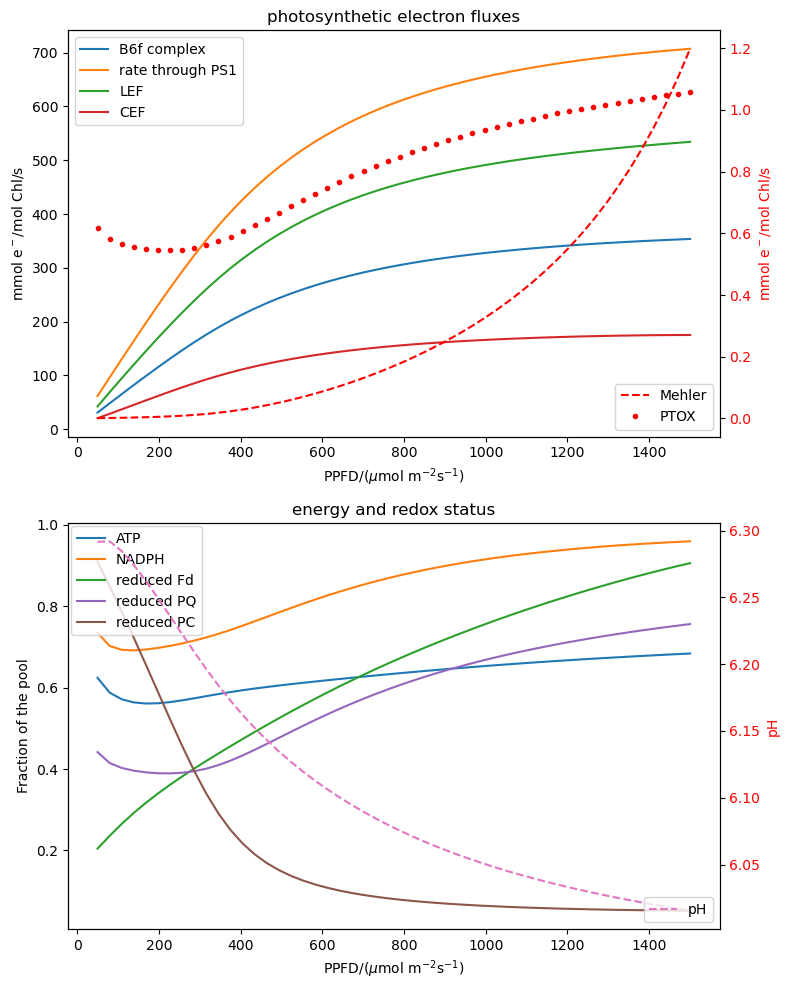

In [16]:
fig, (ax1, ax2) = plt.subplots(2,1 , figsize=(8, 10))
ax1.plot(v["vB6f"], label="B6f complex")
plot_ppfd_petc_steady_state(v, ax1)
(ax21, ax22) = plot_ppfd_redox_steady_state(c, ax2)
ax22.legend(loc="lower right", borderaxespad=0.5)
fig.tight_layout(w_pad=5)
plt.savefig("fig-3-2.png", bbox_inches="tight")
plt.show()

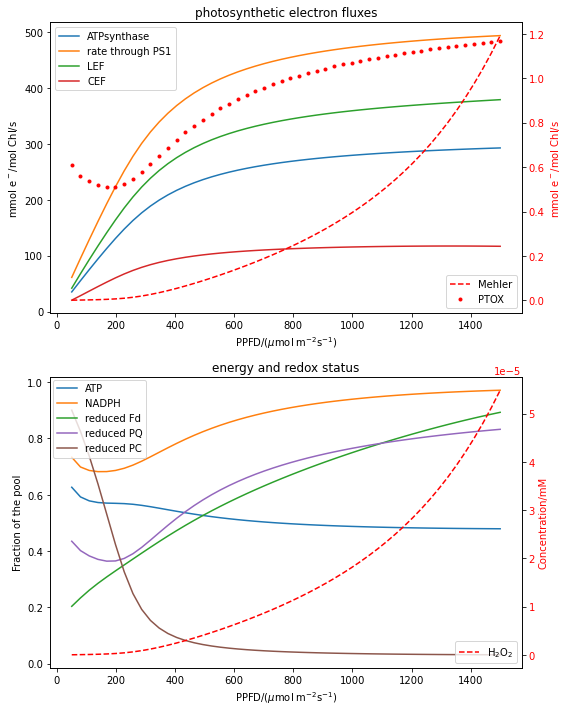

In [20]:
fig, (ax1, ax2) = plt.subplots(2,1 , figsize=(8, 10))
ax1.plot(v["vATPsynthase"], label="ATPsynthase")
plot_ppfd_petc_steady_state(v, ax1)
(ax21, ax22) = plot_ppfd_redox_steady_state(c, ax2)
ax22.legend(loc="lower right", borderaxespad=0.5)
fig.tight_layout(w_pad=5)
plt.savefig("fig-3-2.png", bbox_inches="tight")
plt.show()

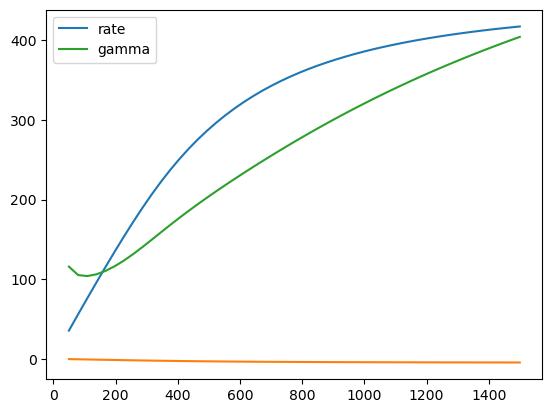

In [14]:
plt.plot(v["vATPsynthase"],label="rate")
plt.plot(c["DeltaGATPsyn"])
plt.plot(c["ATP_gamma"], label="gamma")
plt.legend()

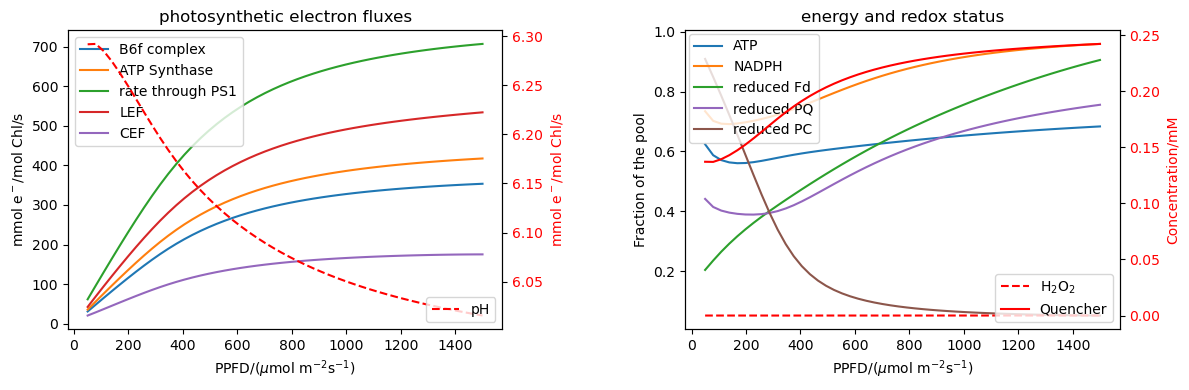

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(v["vB6f"], label="B6f complex")
ax1.plot(v["vATPsynthase"], label="ATP Synthase")
plot_ppfd_petc_steady_state(v, ax1)
(ax21, ax22) = plot_ppfd_redox_steady_state(c, ax2)
ax22.plot(c["Q"], color="red", label="Quencher")
ax22.legend(loc="lower right", borderaxespad=0.5)
fig.tight_layout(w_pad=5)
plt.savefig("fig-3-2.png", bbox_inches="tight")
plt.show()

pfd:   0%|          | 0/50 [00:00<?, ?it/s]

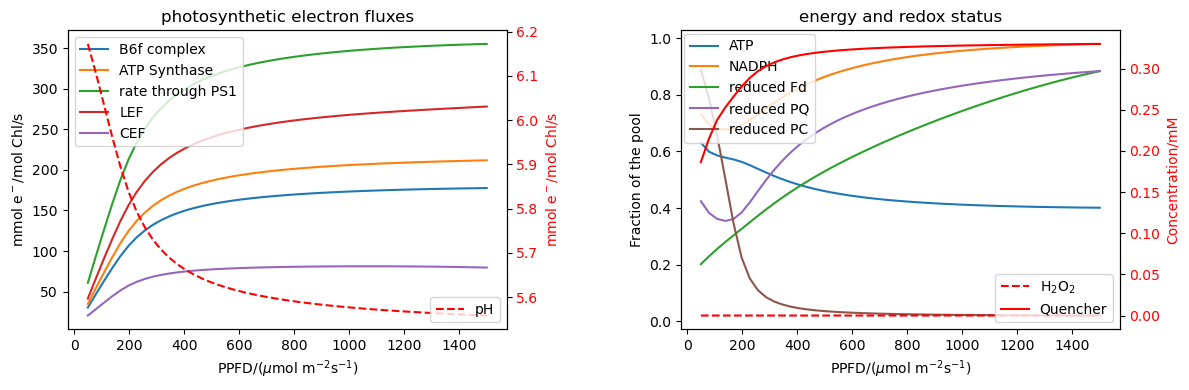

pfd:   0%|          | 0/50 [00:00<?, ?it/s]

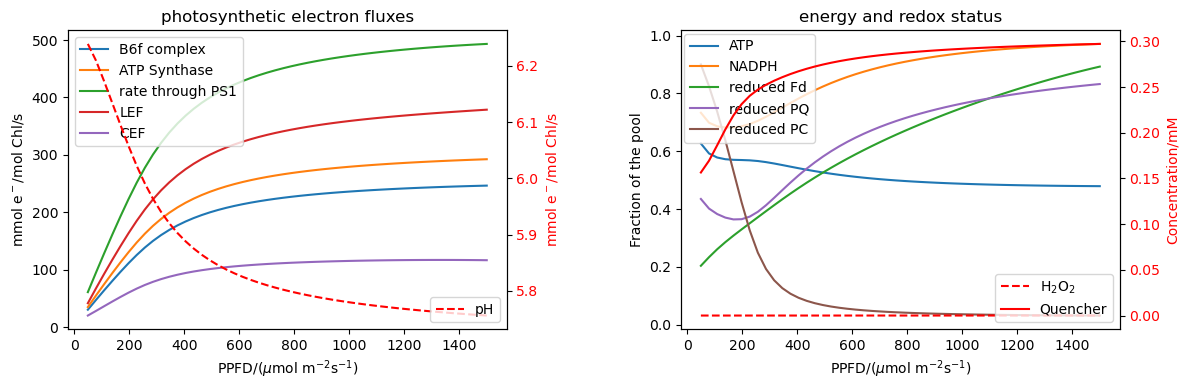

pfd:   0%|          | 0/50 [00:00<?, ?it/s]

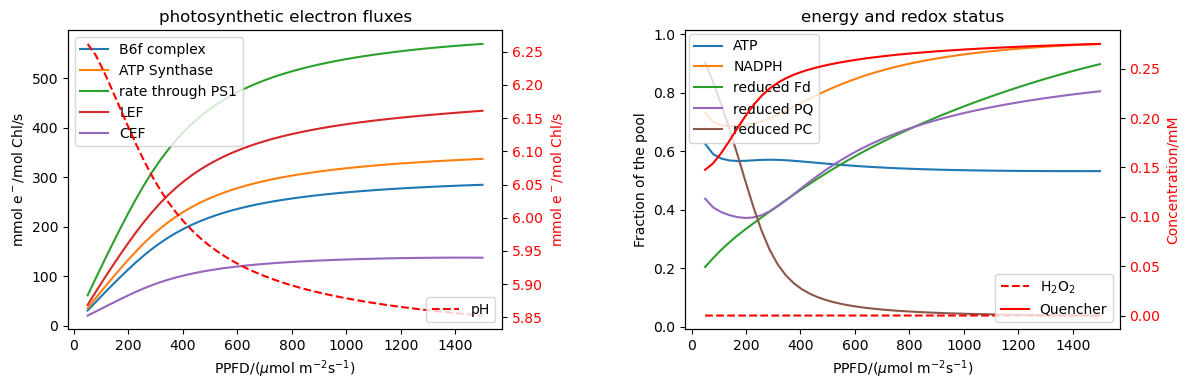

pfd:   0%|          | 0/50 [00:00<?, ?it/s]

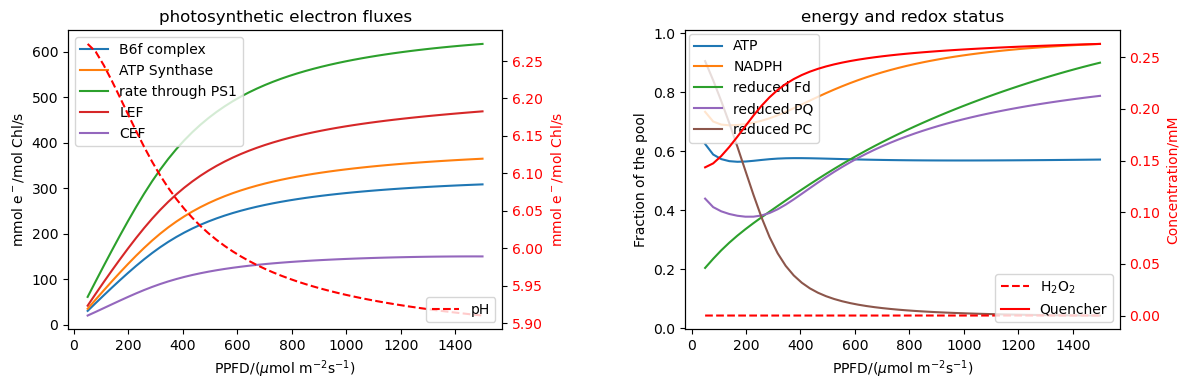

pfd:   0%|          | 0/50 [00:00<?, ?it/s]

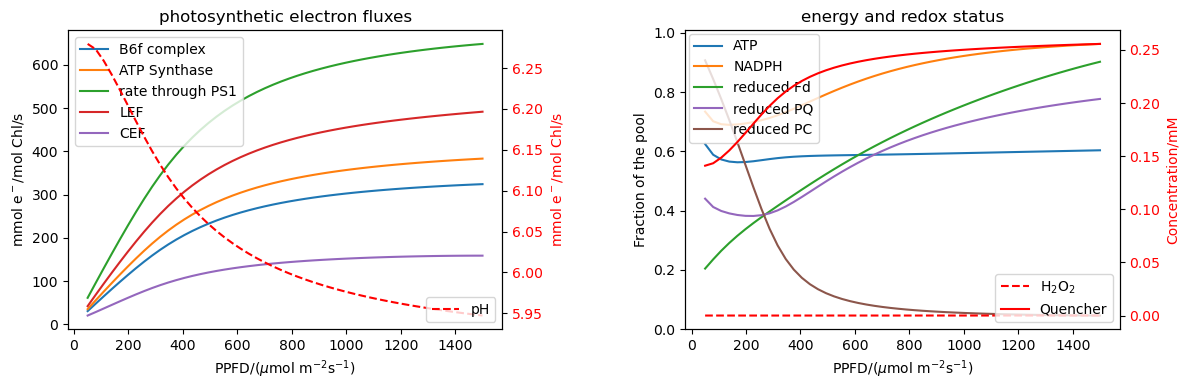

pfd:   0%|          | 0/50 [00:00<?, ?it/s]

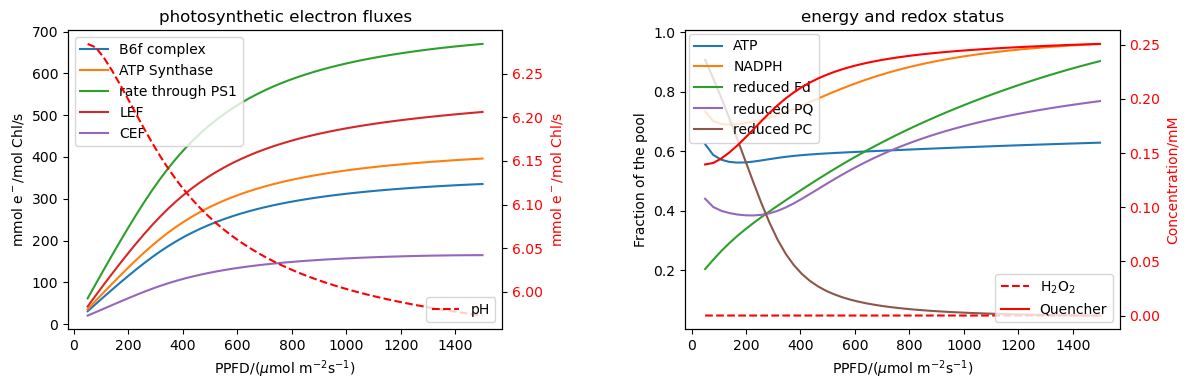

pfd:   0%|          | 0/50 [00:00<?, ?it/s]

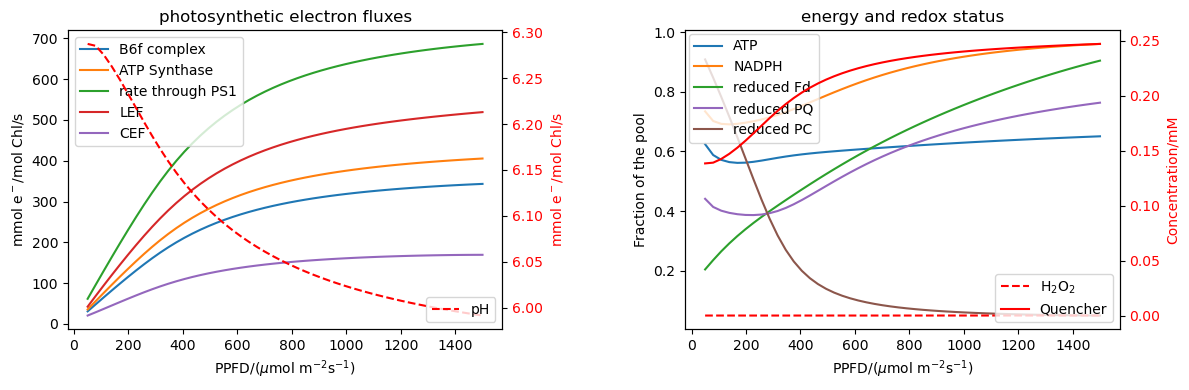

pfd:   0%|          | 0/50 [00:00<?, ?it/s]

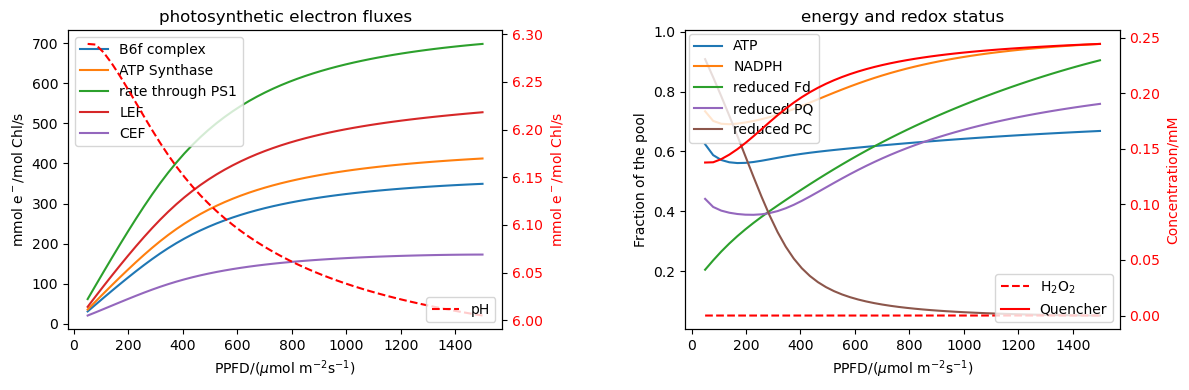

pfd:   0%|          | 0/50 [00:00<?, ?it/s]

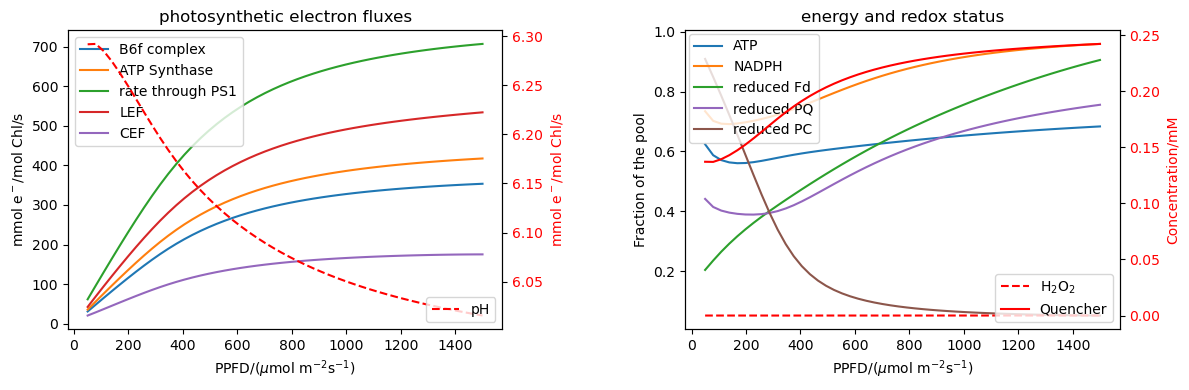

In [17]:
for i in np.linspace(10,200,20):
    s.clear_results()
    s = Simulator(m)
    s.initialise(y0)
    s.update_parameter("ATPturnover",i)
    c, v = s.parameter_scan_with_fluxes(
        "pfd",
        parameter_values=np.linspace(50, 1500, 50),
        multiprocessing=False,
    )
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(v["vB6f"], label="B6f complex")
    ax1.plot(v["vATPsynthase"], label="ATP Synthase")
    plot_ppfd_petc_steady_state(v, ax1)
    (ax21, ax22) = plot_ppfd_redox_steady_state(c, ax2)
    ax22.plot(c["Q"], color="red", label="Quencher")
    ax22.legend(loc="lower right", borderaxespad=0.5)
    fig.tight_layout(w_pad=5)
    plt.savefig("fig-3-2.png", bbox_inches="tight")
    plt.show()

In [19]:
c,v = s.parameter_scan_with_fluxes("ATPturnover", 
                                parameter_values=np.linspace(10,100,50),
                                multiprocessing=False)

ATPturnover:   0%|          | 0/10 [00:00<?, ?it/s]

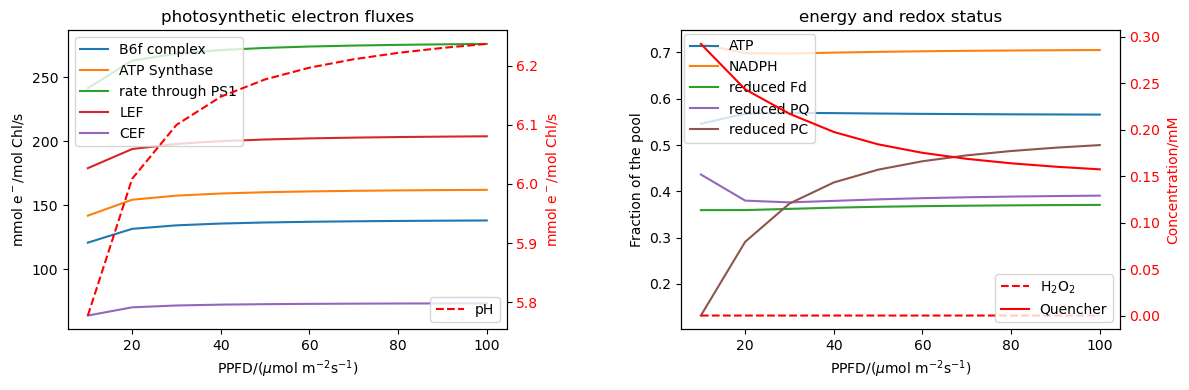

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(v["vB6f"], label="B6f complex")
ax1.plot(v["vATPsynthase"], label="ATP Synthase")
plot_ppfd_petc_steady_state(v, ax1)
(ax21, ax22) = plot_ppfd_redox_steady_state(c, ax2)
ax22.plot(c["Q"], color="red", label="Quencher")   
ax22.legend(loc="lower right", borderaxespad=0.5)
fig.tight_layout(w_pad=5)
plt.savefig("fig-3-2.png", bbox_inches="tight")
plt.show()

In [ ]:
####
#control coefficients
####

In [37]:
from matplotlib.colors import 

In [38]:
def get_new_y0(s):
    return dict(s.get_results_df().iloc[-1])

In [39]:
mca_parameters = {
    "PSIItot": "PS2",
    "PSItot": "PS1",
    "kCytb6f": r"b$_6$f",
    "kcyc": "PGR5",
    "kMehler": "Mehler",
    "V1_base": "RuBisCO",
    "V6_base": "FBPase",
    "V9_base": "SBPase",
    "kcatMDAR": "MDAR",
    "kcat_DHAR": "DHAR",
}

mca_reactions = {
    "vPS2": "PS2",
    "vPS1": "PS1",
    "vB6f": r"b$_6$f",
    "vMehler": "Mehler",
    "vCyc": "CEF",
    "vRuBisCO": "RuBisCO",
    "vFBPase": "FBPase",
    "v9": "SBPase",
    "vMDAreduct": "MDAR",
    "vDHAR": "DHAR",
}

mca_compounds = {
    "PQ_redoxstate": "PQ$_\mathrm{red}$",
    "Fd_redoxstate": "Fd$_\mathrm{red}$",
    "PC_redoxstate": "PC$_\mathrm{red}$",
    "NADP_redoxstate": "NADPH",
    "ATP_norm": "ATP",
    "RUBP": "RUBP",
    "PGA": "PGA",
    "FBP": "FBP",
    "SBP": "SBP",
}

In [40]:
s = Simulator(m)
s.initialise(y0)
s.update_parameter("pfd", 1000)
s.simulate_to_steady_state()
y0_1000 = get_new_y0(s)


s.initialise(y0)
s.update_parameter("pfd", 100)
s.simulate_to_steady_state()
y0_100 = get_new_y0(s)

In [41]:
m.update_parameter("pfd", 1000)
ccc_1000, fcc_1000 = mca.get_response_coefficients_df(
    m,
    mca_parameters,
    y=y0_1000,
    displacement=0.01,
    multiprocessing=False
)

m.update_parameter("pfd", 100)
ccc_100, fcc_100 = mca.get_response_coefficients_df(
    m,
    mca_parameters,
    y=y0_100,
    displacement=0.01,
    multiprocessing=False
)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

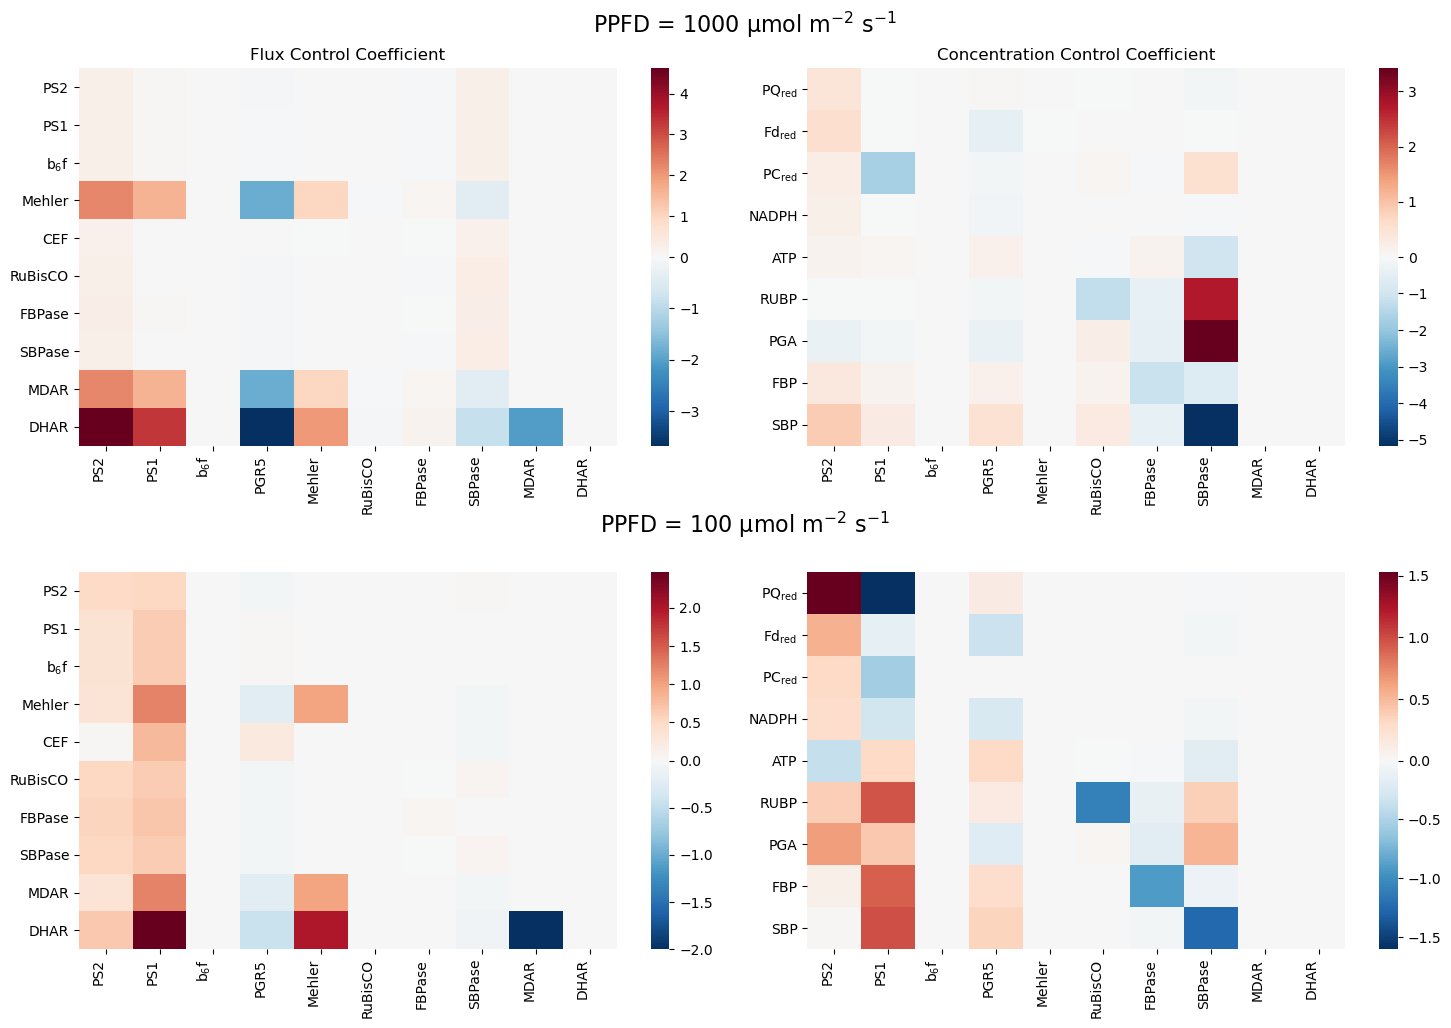

In [42]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
mca.plot_coefficient_heatmap(
    fcc_1000,
    title="Flux Control Coefficient",
    rows=mca_reactions,
    annotate=False,
    ax=ax1,
    norm=TwoSlopeNorm(0),
)
mca.plot_coefficient_heatmap(
    ccc_1000,
    title="Concentration Control Coefficient",
    rows=mca_compounds,
    annotate=False,
    ax=ax2,
    norm=TwoSlopeNorm(0),
)

ax1.set_xticklabels(mca_parameters.values(), rotation=90)
ax1.set_yticklabels(mca_reactions.values())
ax2.set_xticklabels(mca_parameters.values(), rotation=90)
ax2.set_yticklabels(mca_compounds.values())


mca.plot_coefficient_heatmap(
    fcc_100,
    title="",
    rows=mca_reactions,
    annotate=False,
    ax=ax3,
    norm=TwoSlopeNorm(0),
)
mca.plot_coefficient_heatmap(
    ccc_100,
    title="",
    rows=mca_compounds,
    annotate=False,
    ax=ax4,
    norm=TwoSlopeNorm(0),
)

ax3.set_xticklabels(mca_parameters.values(), rotation=90)
ax3.set_yticklabels(mca_reactions.values())
ax4.set_xticklabels(mca_parameters.values(), rotation=90)
ax4.set_yticklabels(mca_compounds.values())
fig.text(
    0.5, 1, "PPFD = 1000 $\mathrm{µmol\ m^{-2}\ s^{-1}}$", fontsize=16, ha="center"
)
fig.text(
    0.5, 0.5, "PPFD = 100 $\mathrm{µmol\ m^{-2}\ s^{-1}}$", fontsize=16, ha="center"
)

fig.tight_layout(h_pad=4)
plt.savefig("fig-6.png", bbox_inches="tight")
plt.show()

In [ ]:
s = Simulator(m)
s.initialise(y0)
s.update_parameter("pKreg", 6.5)
s.update_parameter("max_b6f",600)
s.update_parameter("pfd", 500)
c,v = s.parameter_scan_with_fluxes("pfd", np.linspace(50,1500,10), multiprocessing=False)

pfd:   0%|          | 0/10 [00:00<?, ?it/s]

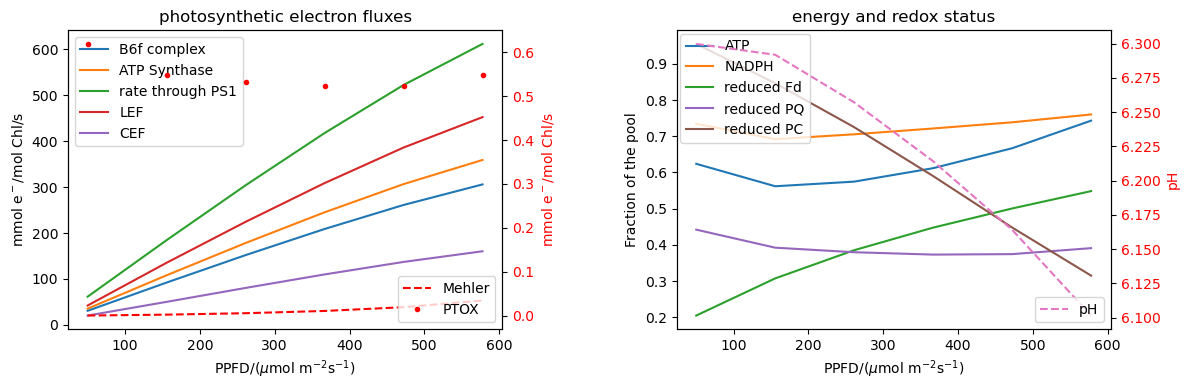

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(v["vB6f"], label="B6f complex")
ax1.plot(v["vATPsynthase"], label="ATP Synthase")
plot_ppfd_petc_steady_state(v, ax1)
(ax21, ax22) = plot_ppfd_redox_steady_state(c, ax2)  
ax22.legend(loc="lower right", borderaxespad=0.5)
fig.tight_layout(w_pad=5)
plt.savefig("fig-3-2.png", bbox_inches="tight")
plt.show()

In [12]:
def par_scan_osc_2d(
    s: Simulator,
    par_name1: str,
    par_values1: Iterable[float],
    par_name2: str,
    par_values2: Iterable[float],
    y0_loop: dict[str, float],
    t_end: float = 100_000,
) -> List[pd.DataFrame]:
    cmin = {}
    cmax = {}
    vmin = {}
    vmax = {}
    cavg = {}
    vavg = {}
    y0_outerloop = y0_loop
    for i, x1 in tqdm(enumerate(par_values1), total=len(par_values1)):
        cmin[x1] = {}
        cmax[x1] = {}
        vmin[x1] = {}
        vmax[x1] = {}
        cavg[x1] = {}
        vavg[x1] = {}
        s.update_parameter(par_name1, x1)
        for j, x2 in tqdm(enumerate(par_values2), total=len(par_values2)):
            if j == 0:
                s.initialise(y0_outerloop)
            else:
                s.initialise(y0_loop)

            s.update_parameter(par_name2, x2)
            t, y = s.simulate(t_end)
            if t is None:
                all_compounds = s.model.get_all_compounds()
                rate_names = s.model.get_rate_names()
                empty_cpds = pd.Series(
                    dict(zip(all_compounds, np.full(len(all_compounds), np.nan)))
                )
                empty_rates = pd.Series(
                    dict(zip(rate_names, np.full(len(rate_names), np.nan)))
                )
                cmin[x1][x2] = empty_cpds
                cmax[x1][x2] = empty_cpds
                cavg[x1][x2] = empty_cpds
                vmin[x1][x2] = empty_rates
                vmax[x1][x2] = empty_rates
                vavg[x1][x2] = empty_rates
            else:
                cmin[x1][x2], cmax[x1][x2], vmin[x1][x2], vmax[x1][x2] = get_minmax(
                    s, t_end
                )
                cavg[x1][x2], vavg[x1][x2] = get_avg(s, t_end)
                y0_loop = get_new_y0(s)

                if j == 0:
                    y0_outerloop = y0_loop

    multidfs = []
    mesh = np.meshgrid(par_values2, par_values1)
    colinds = [x.flatten() for x in mesh]
    for sol in (cmin, cmax, vmin, vmax, cavg, vavg):
        dfs = []
        for i in sol.keys():
            for j in sol[i].keys():
                dfs.append(sol[i][j])
        df3 = pd.DataFrame(
            data=np.array(dfs).T,
            index=dfs[0].index,
            columns=pd.MultiIndex.from_tuples(zip(*colinds)),
        )
        multidfs.append(df3)
    return multidfs

In [13]:
def get_minmax(
    s: Simulator, t_end: float
) -> Tuple[pd.Series, pd.Series, pd.Series, pd.Series]:
    c = s.get_full_results_df()
    v = s.get_fluxes_df()

    cmin = c.loc[t_end * 0.75 :, :].min()
    cmax = c.loc[t_end * 0.75 :, :].max()
    vmin = v.loc[t_end * 0.75 :, :].min()
    vmax = v.loc[t_end * 0.75 :, :].max()

    return cmin, cmax, vmin, vmax


def get_avg(s: Simulator, t_end: float) -> Tuple[pd.Series, pd.Series]:
    c = s.get_full_results_df()
    v = s.get_fluxes_df()

    vavg = pd.Series(
        trapezoid(v.loc[t_end * 0.75 :, :], x=v.loc[t_end * 0.75 :, :].index, axis=0)
        / (t_end - v.loc[t_end * 0.75 :, :].index.min()),
        index=v.columns,
    )

    cavg = pd.Series(
        trapezoid(c.loc[t_end * 0.75 :, :], x=c.loc[t_end * 0.75 :, :].index, axis=0)
        / (t_end - v.loc[t_end * 0.75 :, :].index.min()),
        index=c.columns,
    )

    return cavg.T, vavg.T


In [14]:
def get_new_y0(s):
    return dict(s.get_results_df().iloc[-1])

In [15]:
s = Simulator(m)
s.initialise(y0)

NUM_SCANS = 20
NUM_SCANS = 20
MIN_LOG_F = -3.2
MAX_LOG_F = 3.2
xscale = np.linspace(MIN_LOG_F, MAX_LOG_F, NUM_SCANS)

pfd_vals = np.linspace(40, 1500, 20)
kcyc_vals = np.linspace(10,200,20)

mdfs_cyc = par_scan_osc_2d(s, "pfd", pfd_vals, "ATPturnover", kcyc_vals, y0, t_end=2000)
(cmin, cmax, vmin, vmax, cavg, vavg) = mdfs_cyc

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

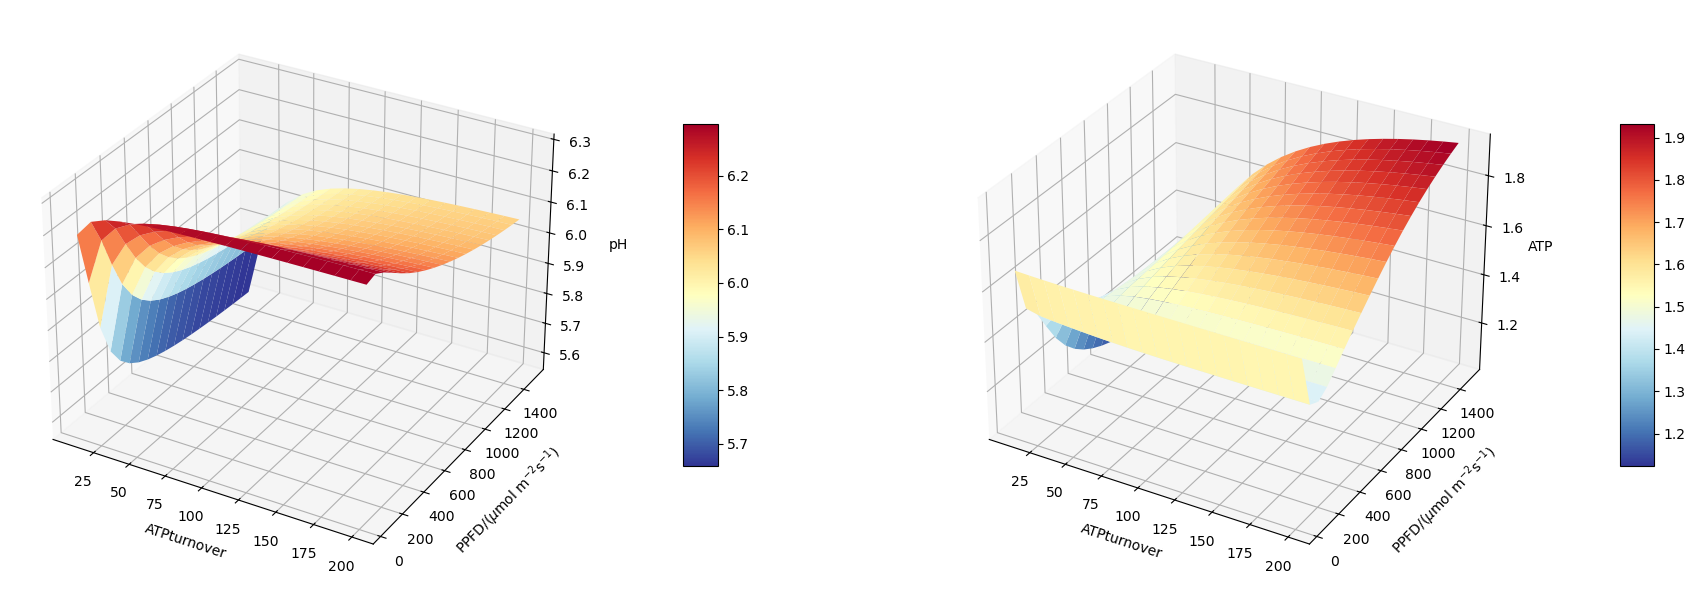

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), subplot_kw={"projection": "3d"})

ax = ax1
surf = ax.plot_surface(
    *np.meshgrid(kcyc_vals, pfd_vals),
    np.array(cavg.loc["pH"]).reshape(20, 20),
    cmap="RdYlBu_r",
    edgecolor="none",
)
ax.set_xlabel("ATPturnover", labelpad=5)
ax.set_ylabel("PPFD/($\mu$mol m$^{-2}$s$^{-1}$)", labelpad=10)
ax.set_zlabel("pH", labelpad=10)
fig.colorbar(surf, shrink=0.6, aspect=10, ax=ax, pad=0.1)

ax = ax2
surf = ax.plot_surface(
    *np.meshgrid(kcyc_vals, pfd_vals),
    np.array(cavg.loc["ATP"]).reshape(20, 20),
    cmap="RdYlBu_r",
    edgecolor="none",
)
ax.set_xlabel("ATPturnover", labelpad=5)
ax.set_ylabel("PPFD/($\mu$mol m$^{-2}$s$^{-1}$)", labelpad=10)
ax.set_zlabel("ATP")
fig.colorbar(surf, shrink=0.6, aspect=10, ax=ax, pad=0.1)
fig.tight_layout()
plt.savefig("fig-7.png", bbox_inches="tight")